# Prerequisites

## Dependencies

In [58]:
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import numpy as np
from cleanvision import Imagelab
from cv2.typing import MatLike
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


class Color(Enum):
    RED = 1
    GREEN = 2
    BLUE = 3


In [2]:
FIGSIZE = (16, 9)

## Dataset

In [3]:
df = pd.read_csv("Dataset/meta_train.csv")
df_original = df.copy()

df.head()

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

# Exploratory Data Analysis

## Metadata and Images Validation

At the very first step of analysing the dataset, make sure every entry of the metadata has its image and vice versa.

In [4]:
import glob

# get all image files, remove directy and save as literal definition (label/image_id)
images = [
    tuple(f.replace("Dataset/train_images/", "").split("/"))
    for f in glob.glob("Dataset/train_images/*/*.jpg")
]

images_df = pd.DataFrame.from_records(images, columns=["label", "image_id"])

# number of images over number of metadata
print(f"{len(images)} images/{df.shape[0]} metadata")

# verify label + image_id equals original dataset
images_df.sort_values(by=["label", "image_id"]).reset_index()[
    ["label", "image_id"]
].equals(df.sort_values(by=["label", "image_id"]).reset_index()[["label", "image_id"]])

10407 images/10407 metadata


True

After verifying through occurences of images and label, check if there is any missing values in metadata.

In [5]:
df.isnull().sum()

image_id    0
label       0
variety     0
age         0
dtype: int64

Here, metadata has no missing values.

## Statistical Overview

After simple data validation, the type of data and further statistical analysis could then be performed on both the metadata and images dataset.

In [6]:
df.describe(include="all").T

count unique         top  freq       mean      std   min   25%  \
image_id    10407  10407  110381.jpg     1        NaN      NaN   NaN   NaN   
label       10407     10      normal  1764        NaN      NaN   NaN   NaN   
variety     10407     10       ADT45  6992        NaN      NaN   NaN   NaN   
age       10407.0    NaN         NaN   NaN  64.043624  8.95883  45.0  60.0   

           50%   75%   max  
image_id   NaN   NaN   NaN  
label      NaN   NaN   NaN  
variety    NaN   NaN   NaN  
age       67.0  70.0  82.0

For metadata dataset, there are 10 unique label types and 10 variety types, with age being in a considerable range of 45 to 82. With that, this data could be categorized into **categorical** (finite number of known values) and **discrete** (numeric in a range of values) feature types, where variety and label being limited - thus **categorial**, and age being **discrete** as it is countable.

### Data Shapes

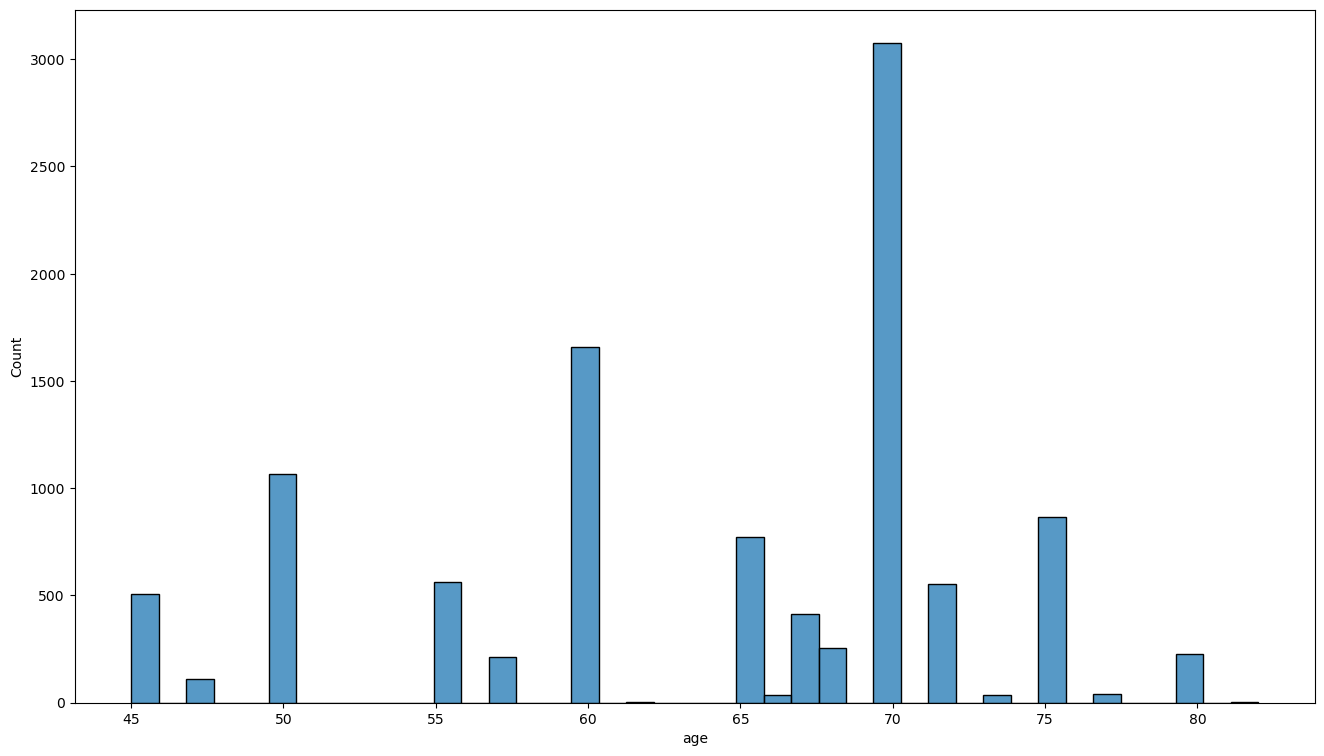

In [7]:
plt.figure(figsize=FIGSIZE)
sns.histplot(data=df, x="age")
plt.show()

First, visualizing age as a **discrete** feature, it has a fairly Gaussian-like distribution, with most values ranging from 60-70, and a noticable dip at ~50-55 and ~60-65.

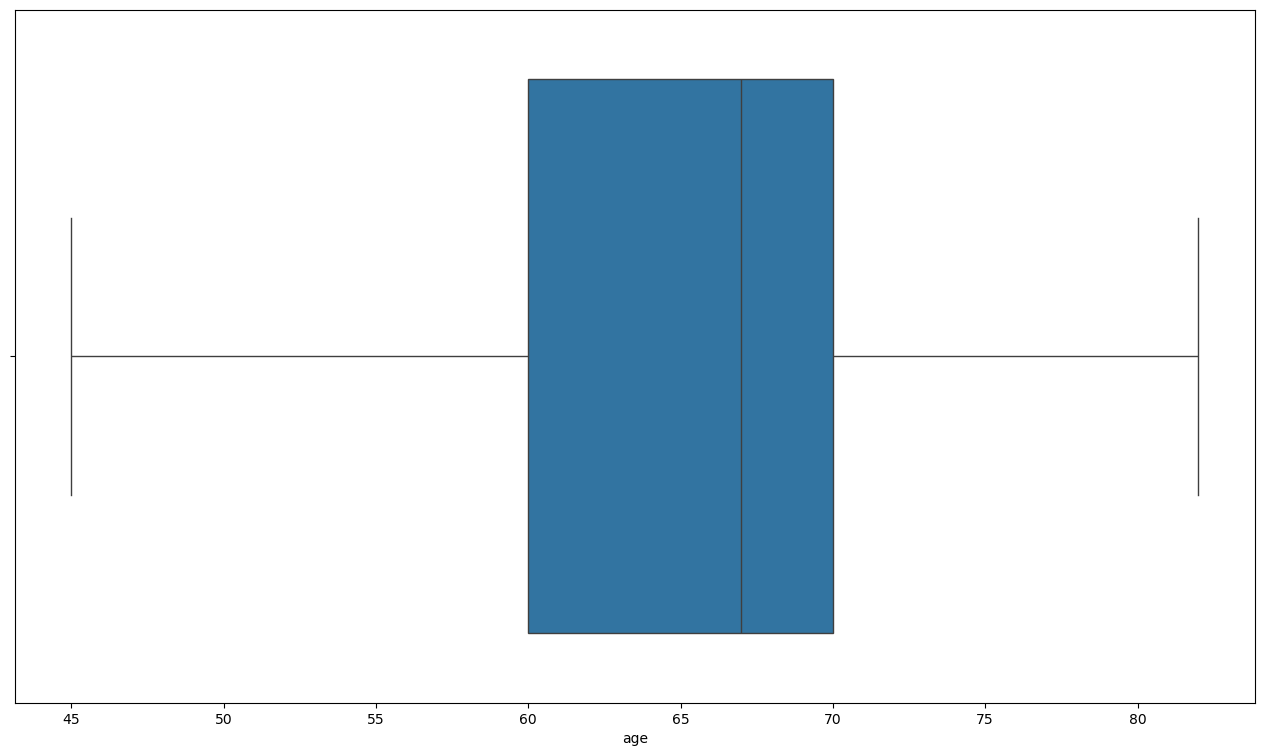

In [8]:
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=df, x="age")
plt.show()

To further demonstrate, age distributed quite well with no outliers found, and its interquartile range both meets the lower and higher range of the data.

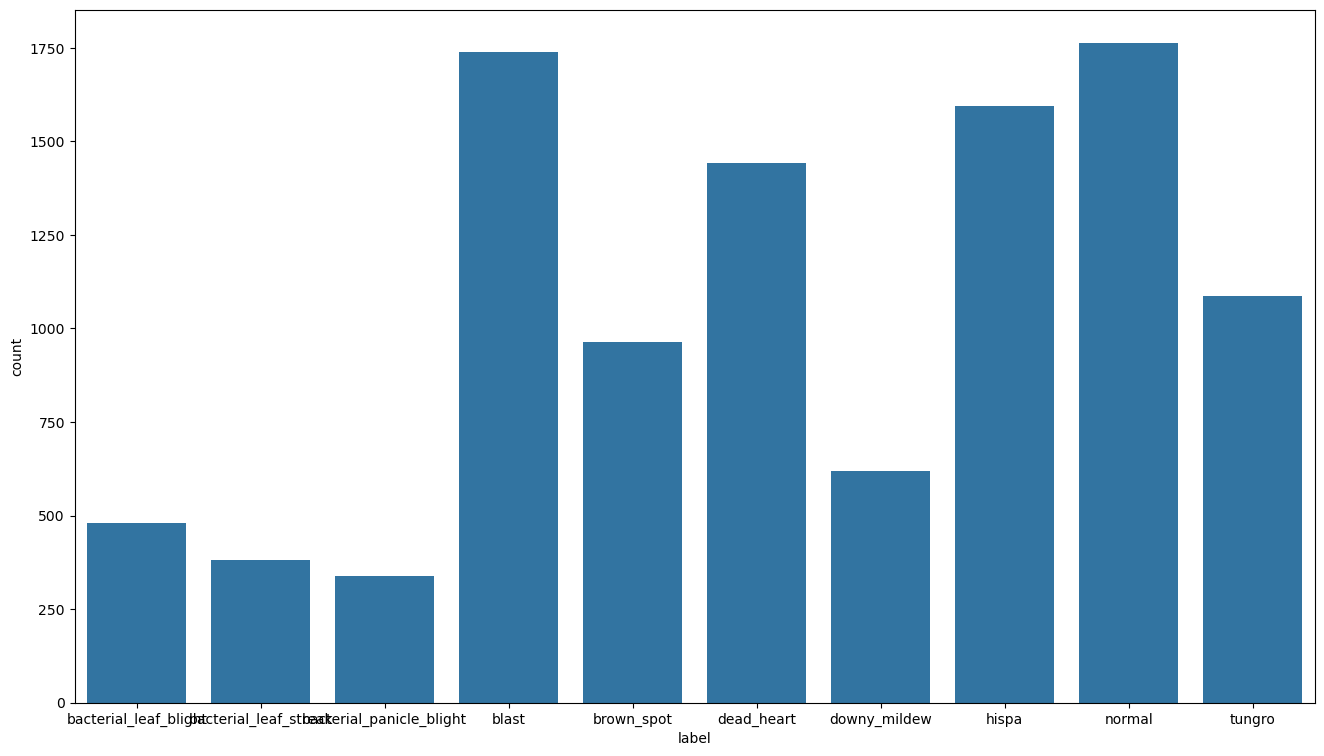

In [9]:
plt.figure(figsize=FIGSIZE)
sns.countplot(data=df, x="label")
plt.show()

Upon looking at the number of disease labels, about half of the dataset has high and mostly equal contribution to the dataset, while other contributes worse. This could be further normalize to improves the quality and balance of the model to make it generalize better.

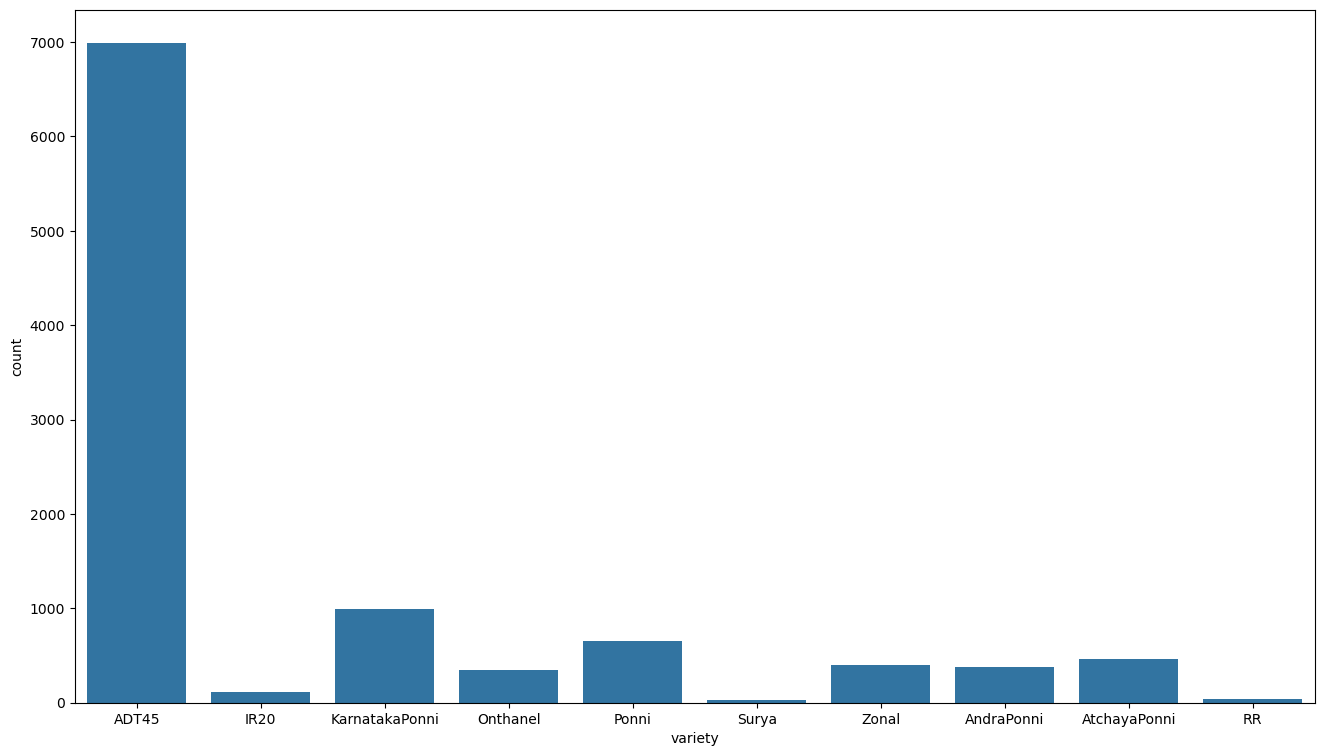

In [10]:
plt.figure(figsize=FIGSIZE)
sns.countplot(data=df, x="variety")
plt.show()

However with the variety of contributing plant of the dataset, `ADT45` is the majority with almost ~7000/10400 images, gaining 67% contribution of all plant types. Here, `RR`, `Surya` and `IR20` has the least data contribution to the dataset.

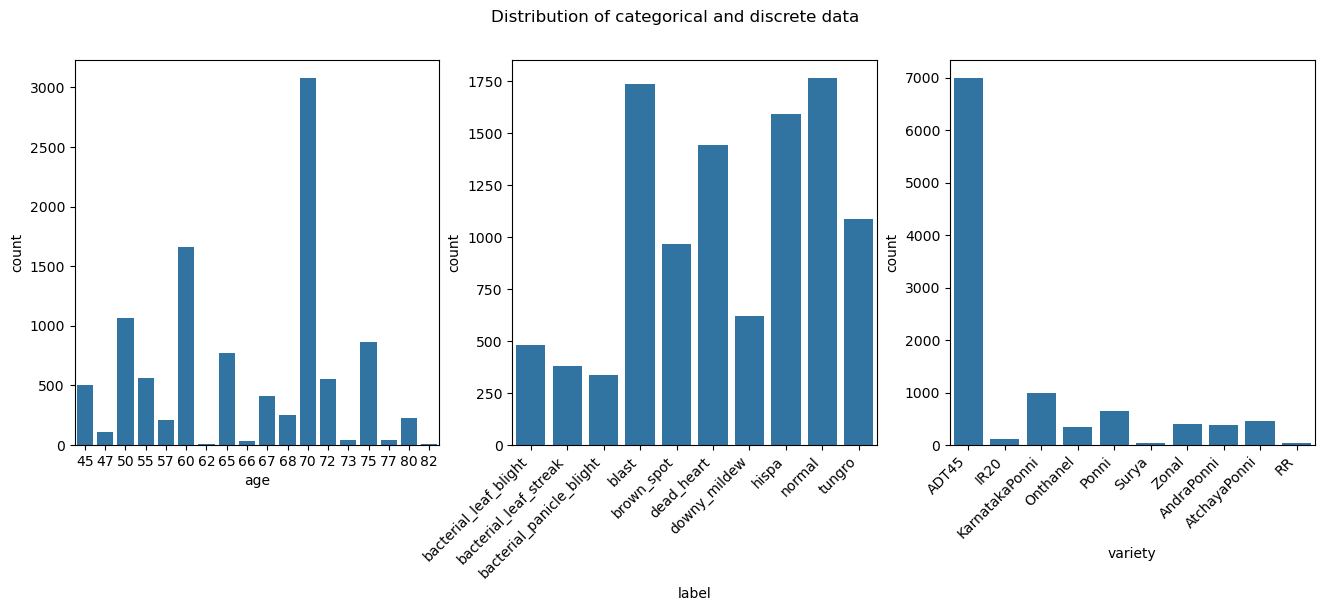

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Distribution of categorical and discrete data")
sns.countplot(data=df, x="age", ax=ax1)
sns.countplot(data=df, x="label", ax=ax2)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right")
sns.countplot(data=df, x="variety", ax=ax3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha="right")
plt.savefig("distribution.svg", bbox_inches="tight")

### Relationships Between Features

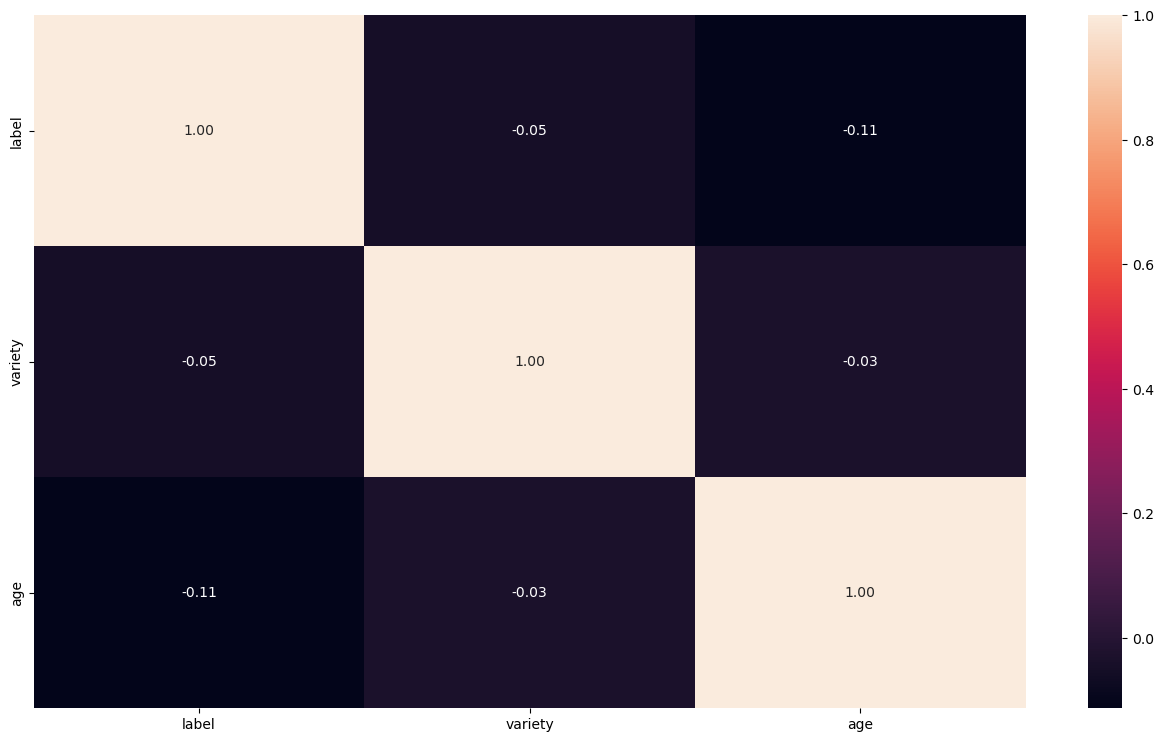

In [11]:
plt.figure(figsize=FIGSIZE)
corr = (
    df.drop("image_id", axis=1)
    .apply(lambda x: pd.factorize(x)[0])
    .corr(method="pearson", min_periods=1)
)
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

Factorize categorial values and plot correlation heatmap to show relationship between features, it is saw that the features correlate quite poorly, as correlation values variate between the 0 mark.

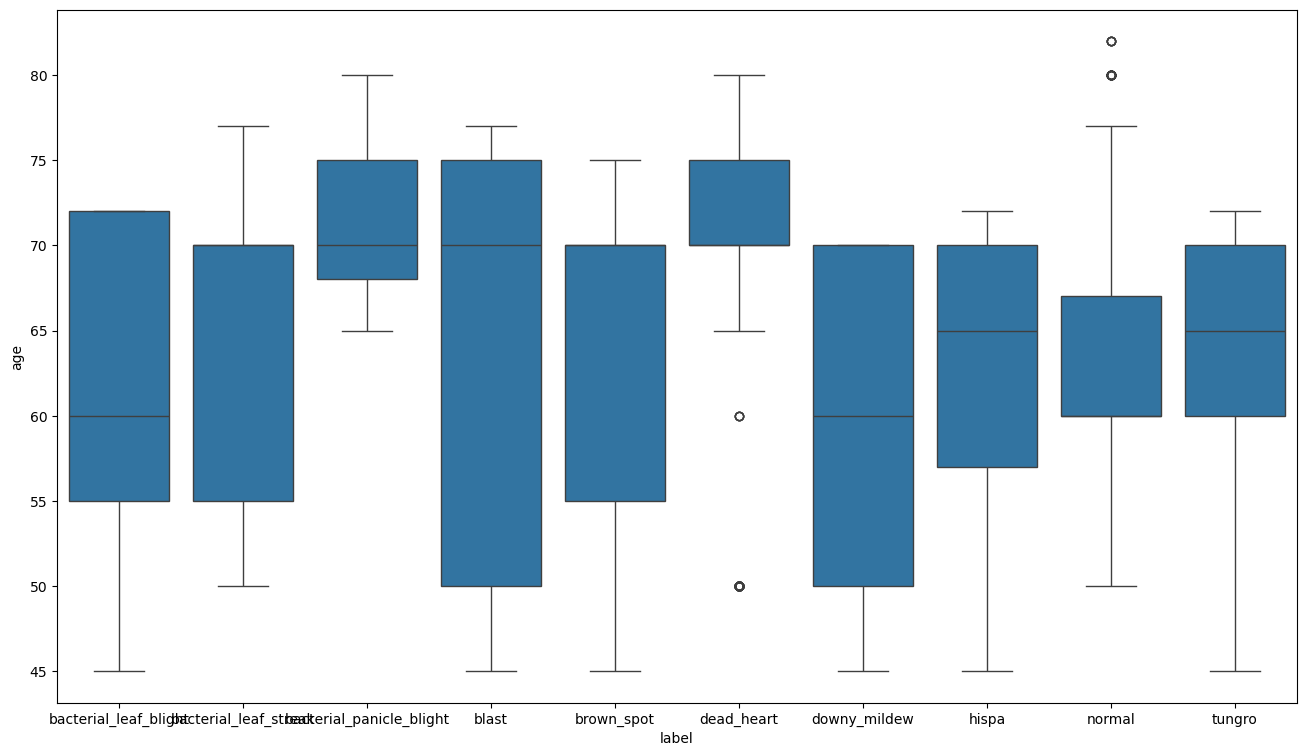

In [12]:
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=df, x="label", y="age")
plt.show()

When compare age to disease label, unhealthy labels tend to has larger interquartile range, while health (`normal`) label variate in between 60-67. Here, small amount of outliers could be seen to contribute to the dataset.

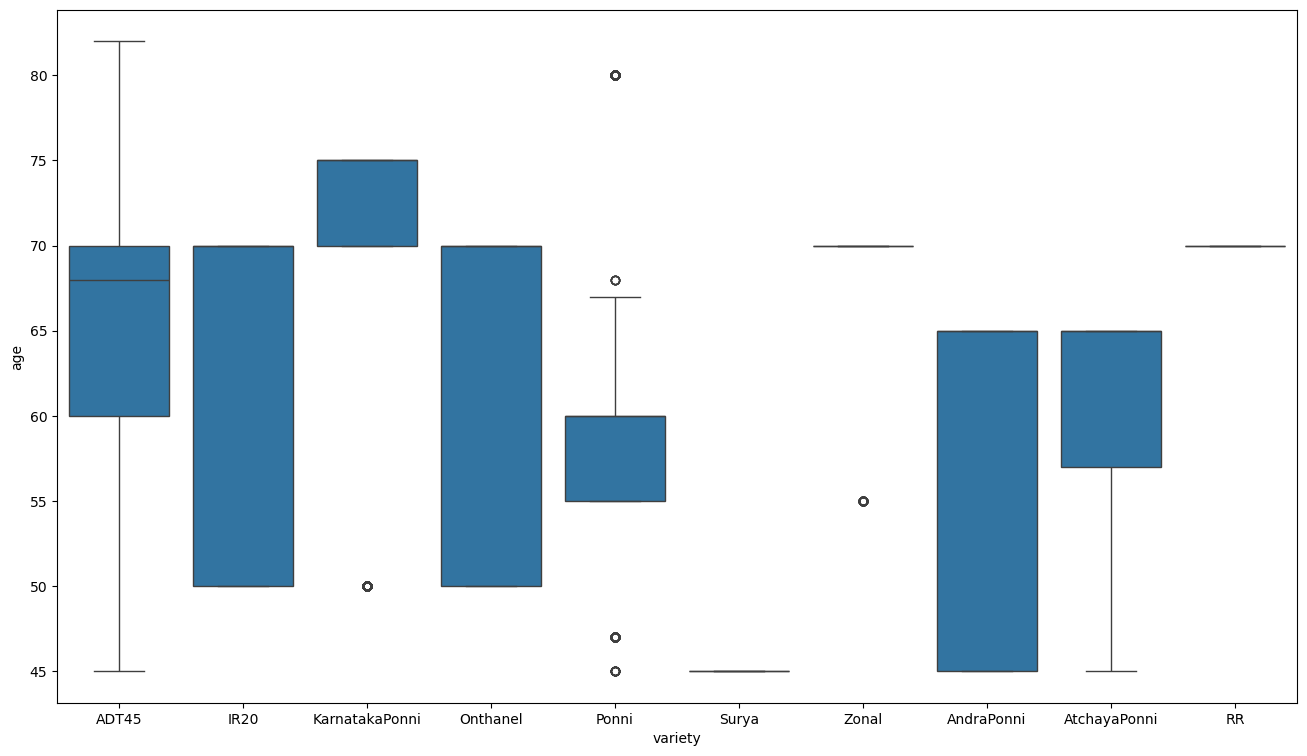

In [13]:
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=df, x="variety", y="age")
plt.show()

However when compare age to variety, `ADT45` has more distributed data with the interquartile range in 60-70, while other variety such as `Surya`, `RR` and `Zonal` are found to has only one age value, and others has more "controlled" values. This aligns well with earlier founding of least data contribution to the dataset of following features.

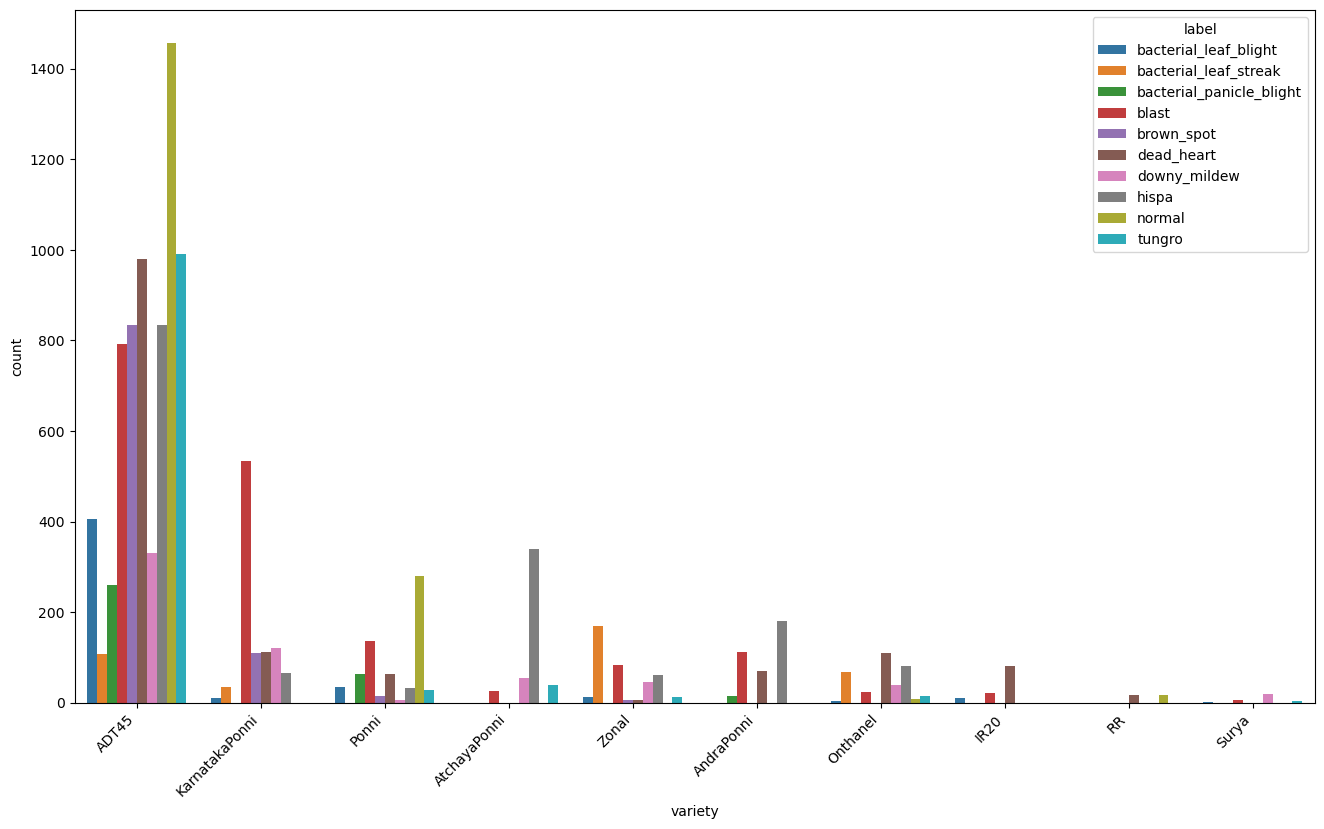

In [14]:
plt.figure(figsize=FIGSIZE)
sns.countplot(
    data=df, x="variety", hue="label", order=df["variety"].value_counts().index
)
plt.xticks(rotation=45, ha="right")
plt.show()

Finally, to demonstrate the contribution of datapoints of `ADT45` to the dataset, most of data comes from only one plant variety, and its distribution could be spot as the majority. By that, further resampling method might be used to improve the performance of trained models later on.

## Image Analysis

### Metadata and Duplicates

In [15]:
imagelab = Imagelab(data_path="Dataset/train_images")
imagelab.find_issues()

Reading images from /home/catou/Codes/school/ml/Rice-Plant-Disease-Classification-/Dataset/train_images
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/10407 [00:00<?, ?it/s]

  0%|          | 0/10407 [00:00<?, ?it/s]

Issue checks completed. 388 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


Apply [CleanVision](https://github.com/cleanlab/cleanvision) on detecting common issues on image dataset, checks are ran to ensure image has normal lighting, sane aspect-ratio, enough information through image size, and if there are exact and almost duplicates in the dataset.

In [16]:
imagelab.info["statistics"]["aspect_ratio"]

count    10407.00
mean         0.75
std          0.00
min          0.75
25%          0.75
50%          0.75
75%          0.75
max          0.75
Name: aspect_ratio, dtype: float64

In [17]:
imagelab.info["statistics"]["size"]

count    1.040700e+04
mean     5.542563e+02
std      1.136923e-13
min      5.542563e+02
25%      5.542563e+02
50%      5.542563e+02
75%      5.542563e+02
max      5.542563e+02
Name: size, dtype: float64

It is found that the dataset has normalized aspect-ratio and image size, consisting of vertically-oriented images of 2:3 aspect ratio - hence the value of 0.75.

In [18]:
imagelab.issue_summary

issue_type  num_images
0   near_duplicates         242
1  exact_duplicates         146
2              dark           0
3             light           0
4  odd_aspect_ratio           0
5            blurry           0
6   low_information           0
7          odd_size           0
8         grayscale           0

However, the dataset consists of about ~400 duplicates, where it should be visualized to link with metadata, and clean before training begins.

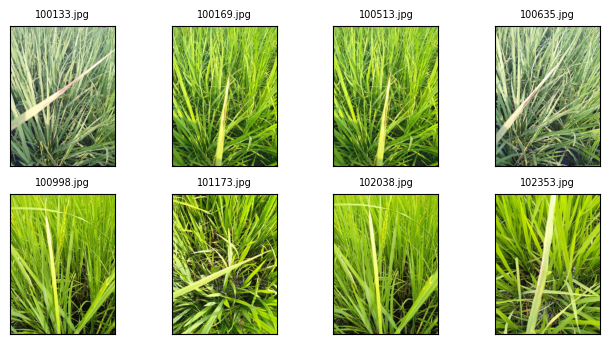

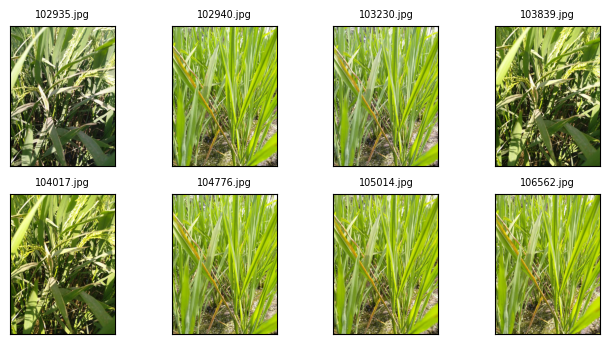

In [19]:
exact_duplicate = imagelab.issues[
    imagelab.issues["is_exact_duplicates_issue"]
].index.tolist()
near_duplicate = imagelab.issues[
    imagelab.issues["is_near_duplicates_issue"]
].index.tolist()
imagelab.visualize(image_files=exact_duplicate[:8])
imagelab.visualize(image_files=near_duplicate[:8])

Upon visualizing some of the exact and near duplicates, same image are spotted to have multiple copies with different file names.

In [20]:
unreliable_sets = []

for set in imagelab.info["exact_duplicates"]["sets"]:
    image_1, image_2 = [set[0].split("/")[-1], set[1].split("/")[-1]]
    meta_1 = (
        df[df["image_id"] == image_1].reset_index().drop(["image_id", "index"], axis=1)
    )
    meta_2 = (
        df[df["image_id"] == image_2].reset_index().drop(["image_id", "index"], axis=1)
    )
    # if comparision has value
    if not meta_1.compare(meta_2).empty:
        unreliable_sets.append(set)
        print("different metadata")

for set in imagelab.info["near_duplicates"]["sets"]:
    image_1, image_2 = [set[0].split("/")[-1], set[1].split("/")[-1]]
    meta_1 = (
        df[df["image_id"] == image_1].reset_index().drop(["image_id", "index"], axis=1)
    )
    meta_2 = (
        df[df["image_id"] == image_2].reset_index().drop(["image_id", "index"], axis=1)
    )
    # if comparision has value
    if not meta_1.compare(meta_2).empty:
        unreliable_sets.append(set)
        print("different metadata")

different metadata
different metadata


Ensuring duplicates has the same metadata, comparison is ran on its filename metadata from the dataset. By this, some duplicates has different metadata, so removing the image and its metadata without imputing is possible, by dropping unreliable column that has different metadata while maintaining the same image.

In [21]:
for set in imagelab.info["exact_duplicates"]["sets"]:
    for i in range(len(set)):
        if i != 0:
            df = df[df["image_id"] != set[i].split("/")[-1]]

for set in imagelab.info["near_duplicates"]["sets"]:
    for i in range(len(set)):
        if i != 0:
            df = df[df["image_id"] != set[i].split("/")[-1]]

for set in unreliable_sets:
    for i in range(len(set)):
        df = df[df["image_id"] != set[i].split("/")[-1]]

Then, both duplicates and unreliable images are removed from the metadata set.

In [22]:
df.shape

(10201, 4)

With that, the training dataset saw a reduction of about only 2%.

### Colour Featuring

In [ ]:
colour_distributions = [[], [], []]
low_green_images = []

for i, [name, label] in df[["image_id", "label"]].iterrows():
    image = cv.imread(f"Dataset/train_images/{label}/{name}")
    for i, _ in enumerate(("b", "g", "r")):
        # if colourspace is green, calculate weighted green values based on histogram
        if i == 1:
            green_hist = cv.calcHist([image], [i], None, [256], [0, 256])
            green_value = sum(i * w for i, w in enumerate(green_hist)) / sum(green_hist)
            # store images that has low value (distributed with less than half)
            if green_value < 256 / 2:
                low_green_images.append(f"Dataset/train_images/{label}/{name}")
        colour_distributions[i].append(cv.calcHist([image], [i], None, [256], [0, 256]))

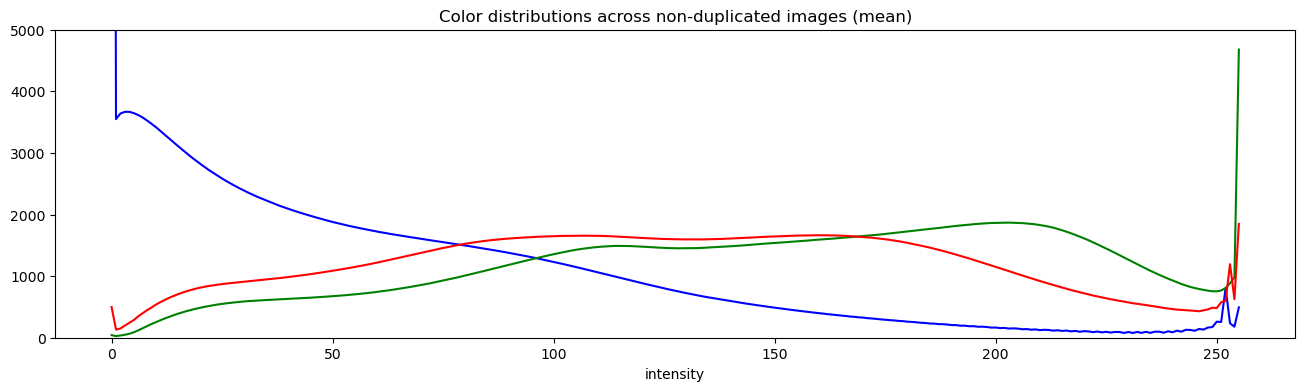

In [24]:
plt.figure(figsize=(16, 4))
plt.title("Color distributions across non-duplicated images (mean)")
plt.xlabel("intensity")
plt.plot(np.mean(colour_distributions[0], axis=0), color="b")
plt.plot(np.mean(colour_distributions[1], axis=0), color="g")
plt.plot(np.mean(colour_distributions[2], axis=0), color="r")
ax = plt.gca()
ax.set_ylim([0, 5000])
plt.savefig("color-distribution.svg", bbox_inches="tight")
plt.show()

Plotting colour distributions across all images, it could be seen that in higher pixel intensity (x > 150), green colourspace has the majority due to image being capture of plants.

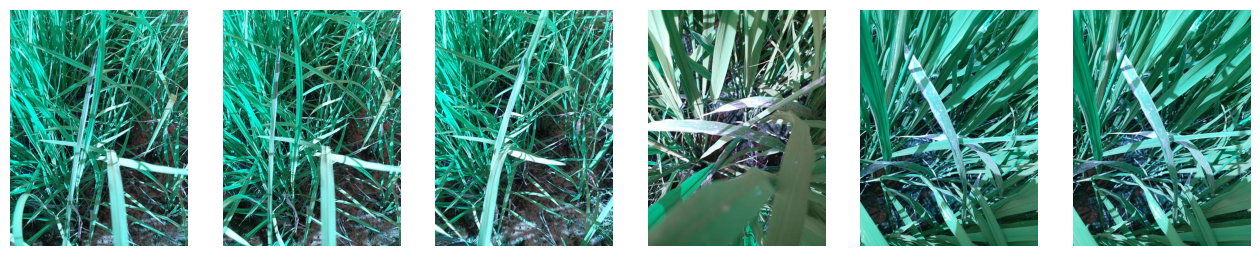

In [57]:
_, axs = plt.subplots(1, 6, figsize=FIGSIZE)

for i, _ in enumerate(axs.ravel()):
    # sample from 50 -> 56
    image = cv.imread(low_green_images[i + 50])
    axs[i].imshow(image)
    axs[i].axis("off")

plt.show()

Sample some images that has low green intensity, some could be spotted due to environmental colour changes or capturing with incorrect "white balance" setting resulting in colour has more significant blue hues. This could be in consideration to further experiment in training to see if model performance would improve with some of above images removed.

In [ ]:
sample = [
    cv.imread("Dataset/train_images/normal/100002.jpg"),
    cv.imread("Dataset/train_images/blast/100147.jpg"),
    cv.imread("Dataset/train_images/brown_spot/100158.jpg"),
    cv.imread("Dataset/train_images/dead_heart/100116.jpg"),
    cv.imread("Dataset/train_images/hispa/110380.jpg"),
    cv.imread("Dataset/train_images/bacterial_panicle_blight/110162.jpg"),
]

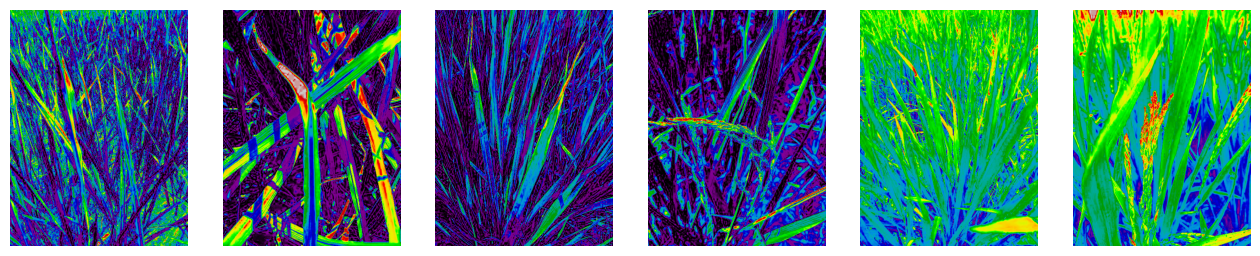

In [ ]:
_, axs = plt.subplots(1, 6, figsize=FIGSIZE)

for i, _ in enumerate(axs.ravel()):
    # https://matplotlib.org/stable/tutorials/images.html
    axs[i].imshow(sample[i][:, :, 0], cmap="nipy_spectral")
    axs[i].axis("off")

plt.savefig("nipy.svg", bbox_inches="tight")
plt.show()

Then, sample some of the images, flatten out the colourspace by disabling "blue" channel and apply ["nipy" colourmap](https://www.frontiersin.org/journals/neuroinformatics/articles/10.3389/fninf.2011.00013/full) to highlights intensity of the red channel.

By that, small chunk of "highlights" in red of above image could be seen as a differentiate factor that could plays a major role in training our model, where each image consists of multiple information sources.

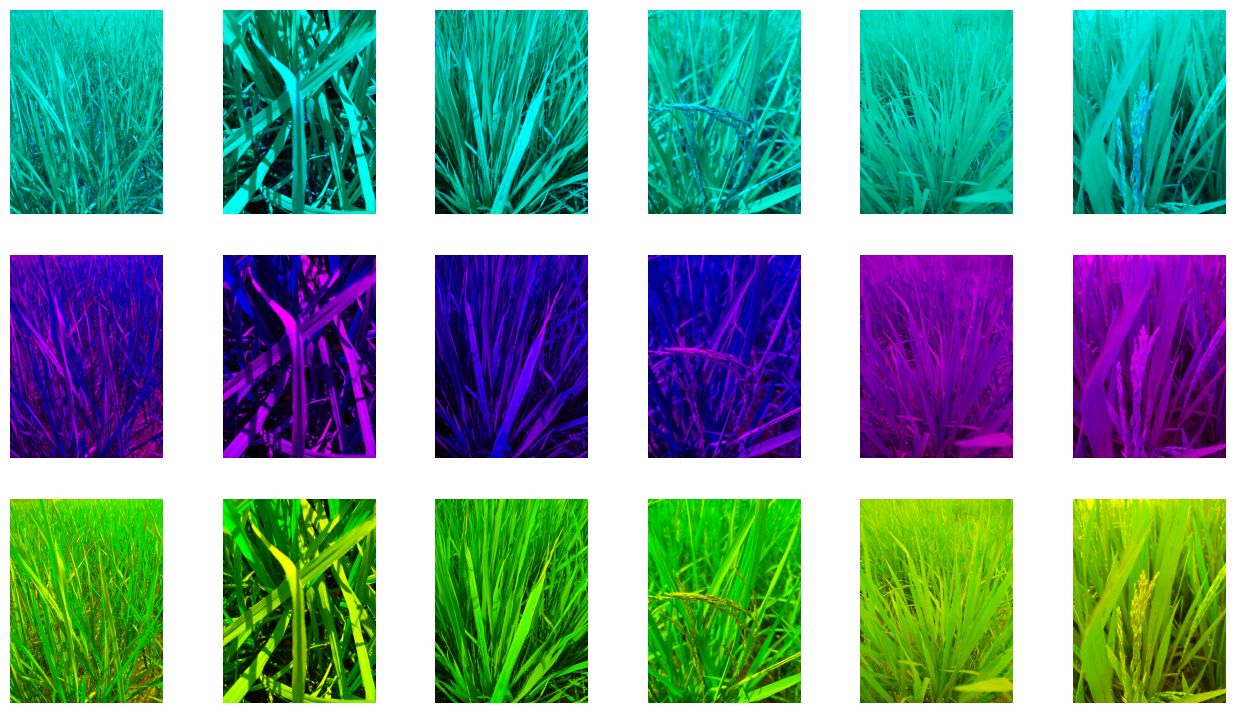

In [ ]:
_, axs = plt.subplots(3, 6, figsize=FIGSIZE)


def disable_color(img: MatLike, color: Color) -> MatLike:
    img = img.copy()
    match color:
        case Color.RED:
            img[:, :, 2] = 0
        case Color.GREEN:
            img[:, :, 1] = 0
        case Color.BLUE:
            img[:, :, 0] = 0

    return img


for i in range(6):
    axs[0, i].imshow(disable_color(sample[i], Color.BLUE))
    axs[1, i].imshow(disable_color(sample[i], Color.GREEN))
    axs[2, i].imshow(disable_color(sample[i], Color.RED))
    axs[0, i].axis("off")
    axs[1, i].axis("off")
    axs[2, i].axis("off")

plt.show()

Moreover, experimenting with a single colour channel disabled, on green channel disabled, some information about the image could be gain in small edges, especially in `brown_spot` where clear distinction of colours near the edge could be seen.

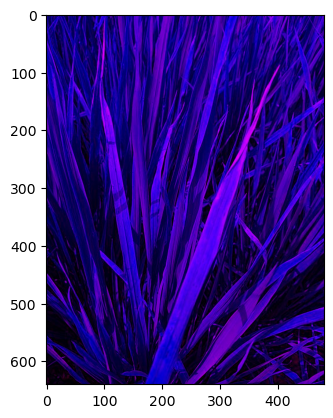

In [74]:
plt.imshow(disable_color(sample[2], Color.GREEN))
plt.show()